# 2/2021 Data Analysis

This notebook contains code associated with validating and analyzing CPC/Raspi logging associated with the sensor box prior to deployment in Revere in March 2021. I will start by just loading and exploring the datasets, and then I will explore the extent of the accuracy and reliability associated with the raspberry pi's data logging. Hopefully this file is useful for iterating on the sensor box and also can serve as a reference/container of boilerplate code for future CPC/raspberry pi logs data analysis work. In the context of current progress, I'll create issues in the logger repository for different failures and link them here. Note that a lot of this is very unoptimized code but should be fine for this one-off test, but probably should not be an example of what good data analysis strategies or coding practices look like.

In [74]:
import bisect
from collections import Counter
import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

First, parse the data recorded by the CPC itself.

In [75]:
cpc = pd.read_csv('data/cpc-logged-data.txt', sep='\t');
cpc.describe()

,aveconc,concent,rawconc,cnt_sec,condtmp,satttmp,satbtmp,optctmp,inlttmp,smpflow,...,condpwr,sattpwr,satbpwr,optcpwr,satfpwr,exhfpwr,fillcnt,err_num,mcpcpmp,mcpcpwr
count,91185.000000,91185.000000,91185.000000,91185.000000,91185.000000,91185.000000,91185.000000,91185.000000,91185.000000,91185.000000,...,91184.000000,91184.000000,91184.000000,91184.000000,91184.000000,91184.0,91184.000000,91184.0,91184.0,91184.0
mean,637.529407,637.609400,630.513211,3559.149597,21.978993,47.421997,46.996892,32.098040,31.742437,338.022361,...,249.318422,0.514443,66.057740,17.678705,43.170622,200.0,0.002358,0.0,1.0,1.0
std,1227.801271,1227.686741,1208.463286,6823.936140,2.057860,2.187245,2.247951,2.092854,2.238682,1.856988,...,9.104697,9.825600,28.358681,16.470893,1.318105,0.0,0.057406,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,18.400000,18.800000,18.800000,19.100000,19.200000,71.000000,...,0.000000,0.000000,0.000000,0.000000,29.000000,200.0,0.000000,0.0,1.0,1.0
25%,0.000000,0.530000,0.530000,3.000000,20.600000,46.000000,45.600000,30.700000,30.500000,337.000000,...,250.000000,0.000000,45.000000,0.000000,42.000000,200.0,0.000000,0.0,1.0,1.0
50%,99.000000,99.870000,99.870000,562.000000,21.300000,46.800000,46.400000,31.400000,31.300000,338.000000,...,250.000000,0.000000,45.000000,26.000000,43.000000,200.0,0.000000,0.0,1.0,1.0
75%,506.000000,505.000000,505.000000,2854.000000,22.800000,48.300000,47.900000,33.000000,32.800000,339.000000,...,250.000000,0.000000,91.000000,26.000000,44.000000,200.0,0.000000,0.0,1.0,1.0
max,5730.000000,5730.000000,5604.000000,31177.000000,28.800000,54.400000,53.900000,38.900000,37.700000,427.000000,...,250.000000,200.000000,200.000000,200.000000,73.000000,200.0,3.000000,0.0,1.0,1.0


Next, parse the data collected on the raspi.

In [76]:
raspi = pd.read_csv('data/raspi-logged-data.csv');
raspi.describe()

,concent,rawconc,cnt_sec,condtmp,satttmp,satbtmp,optctmp,inlttmp,smpflow,satflow,...,condpwr,sattpwr,satbpwr,optcpwr,satfpwr,exhfpwr,fillcnt,err_num,mcpcpmp,mcpcpwr
count,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,...,54272.000000,54272.0,54272.000000,54272.000000,54272.000000,54272.0,54272.000000,54272.0,0.0,0.0
mean,832.132866,822.539761,4643.132812,20.970677,46.456383,46.026273,31.088816,30.818142,338.060455,338.109393,...,249.602189,0.0,65.569926,17.942770,42.597564,200.0,0.002248,0.0,NaN,NaN
std,1374.440554,1352.582235,7638.008854,0.776005,0.760655,0.778519,0.795496,1.029014,1.531202,1.637550,...,0.820690,0.0,26.013666,15.011424,0.531678,0.0,0.053222,0.0,NaN,NaN
min,0.000000,0.000000,0.000000,19.800000,45.300000,44.700000,29.800000,28.600000,318.000000,329.000000,...,247.000000,0.0,0.000000,0.000000,40.000000,200.0,0.000000,0.0,NaN,NaN
25%,0.880000,0.880000,5.000000,20.100000,45.700000,45.200000,30.300000,30.100000,337.000000,337.000000,...,250.000000,0.0,45.000000,0.000000,42.000000,200.0,0.000000,0.0,NaN,NaN
50%,219.100000,219.100000,1234.000000,21.000000,46.500000,46.100000,31.200000,31.000000,338.000000,338.000000,...,250.000000,0.0,45.000000,26.000000,43.000000,200.0,0.000000,0.0,NaN,NaN
75%,738.800000,738.800000,4161.000000,21.500000,47.000000,46.600000,31.600000,31.500000,339.000000,340.000000,...,250.000000,0.0,91.000000,26.000000,43.000000,200.0,0.000000,0.0,NaN,NaN
max,5078.000000,4979.000000,28193.000000,22.900000,48.300000,48.000000,33.100000,33.000000,347.000000,343.000000,...,250.000000,0.0,200.000000,200.000000,45.000000,200.0,2.000000,0.0,NaN,NaN


# Pre-Processing
I'll start by converting all of the timestamps in each of the files to indexed datetime objects.

In [91]:
# For CPC data.
index = []
for date, time in zip(cpc['#YY/MM/DD'], cpc['HR:MN:SC']):
    Y = int(date[:2]) + 2000
    M = int(date[3:5])
    D = int(date[6:8])
    H = int(time[:2])
    T = int(time[3:5])
    S = int(time[6:8])
    index.append(dt.datetime(Y, M, D, H, T, S))
cpc.index = index

In [92]:
# For Raspi Data
index = []
for timestamp in raspi['#YY/MM/DD:HR:MN:SC']:
    Y = int(timestamp[:4])
    M = int(timestamp[5:7])
    D = int(timestamp[8:10])
    H = int(timestamp[11:13])
    T = int(timestamp[14:16])
    S = int(timestamp[17:19]) # Truncates value instead of rounding
    index.append(dt.datetime(Y, M, D, H, T, S))
raspi.index = index

# Sampling Timestamp Validation

## Timing Window
We conducted this test between approximately 8:25 AM on 2/17/2021 and 9:45 AM on 2/18/2021, so we would expect to see those start and end indices in the data logs.
### CPC
We can pull the start and end values of the indexed timestamps to find the range.

In [93]:
print(f'Start time: {cpc.index[0]}')
print(f'End time: {cpc.index[-1]}')

Start time: 2021-02-17 08:25:05
End time: 2021-02-18 09:44:50


The range here generally reflects the full range of the experiment (with potentially seconds lost on either end); this is sufficient performance for this iteration.

### Raspberry Pi
We can pull the start and end values of the indexed timestamps to find the range. It is important to note that the timestamps here are from the raspberry pi itself, but for this and also for reasons mentioned in the logging accuracy section it would be nice to investigate pulling timestamps directly from the CPC. See [issue 44](https://github.com/airpartners/logger/issues/44) for more context and updates.

In [94]:
print(f'Start time: {raspi.index[0]}')
print(f'End time: {raspi.index[-1]}')

Start time: 2021-02-17 15:01:38
End time: 2021-02-18 09:45:10


It looks like the raspberry pi is missing about six and a half hours of data from the very beginning of the experiment. See [Issue 29](https://github.com/airpartners/logger/issues/29) for additional updates and context, but we need to ensure that we are logging all of the CPC data. 

The analysis of the valve switching state indicates there was some inconsistency here in terms of the valve as well, so it's possible that it just got unplugged or something: if that's the case, we need to figure out why it lost data instead of appending to the file. There are definitely some more pieces to fix before doing another 24 hour test, but if there's no solution it might be worth just trying again. 

## Frequency
### CPC
The settings on the CPC that we operate with indicate that we should see data updates at a 1 Hz cadence. I'll double checking this by taking a look at the differences between each of the timestamps.

In [95]:
# Compare every element to the previous.
cpc_timestamp_deltas = pd.Series((cpc[1:].index - cpc[:-1].index).seconds)
cpc_timestamp_deltas.value_counts()

1    91183
2        1
dtype: int64

This is almost perfect in its cadence save for a single inconsistency in the middle of the dataset. While I am not sure why this is the case, it's a single inconsistency out of 100,000 data points, which is within a tolerable range of error for the purpose of this application, at least while there are more pressing concerns present as well. It might be worth bringing up in the context of a larger discussion with Brechtel at some point, but I don't feel ready to call it an issue.

### Raspberry Pi
The next thing I will do is evaluate the logging cadence on the raspberry pi, which is a lot more inconsistent. It's first worth evaluating the range and extent of these inconsistencies. 

In [96]:
raspi_timestamp_deltas = pd.Series((raspi[1:].index - raspi[:-1].index).seconds)
counts = raspi_timestamp_deltas.value_counts()
counts

1    41130
2    13141
dtype: int64

It looks like there's quite a bit of skipping happening within the system, so I'll next take a look at the distribution of those skips. Visualizing different sections of this indicates that the shifts are pretty evenly distributed throughout. You can change the `start_bin` variable to see this; I tried like 20 or so points between 1 and 50,000 and saw this pattern (not a fixed width difference between skips, but no places where its sparse). 

<StemContainer object of 3 artists>

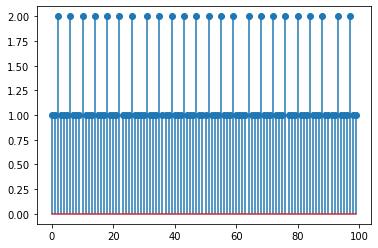

In [97]:
start_bin = 50000
number_of_points = 100
plt.stem(raspi_timestamp_deltas[start_bin:start_bin + number_of_points], use_line_collection=True)

We can also do some more rigorous analysis of the cadence to inform debugging. First, we can take a look at the average number of skips in a certain window. We'll work with the `raspi_timestamp_deltas` variable and use the fact that we know all of the gaps are either one or two seconds to speed things up. 

In [100]:
freq_width = 5 # Number of points per window
skips = [] # Number of values that equal 2 
skip_time = 2
for i in range(int(len(raspi_timestamp_deltas)/ freq_width)):
    window = raspi_timestamp_deltas[i*freq_width: i*freq_width + freq_width].values
    skips.append(list(window).count(skip_time))
Counter(skips)

Counter({1: 8567, 2: 2287})

It looks like there are 1-2 skips every 5 data points throughout the entire dataset: there is literally no five second period without at least a single skipped data point. This failure is a pretty major issue in the context of this project, as we need at least 1 Hz granularity to just use the Raspberry Pi as a logger instead of having to deal with uncorrelated timestamps from the CPC. See [issue 40](https://github.com/airpartners/logger/issues/40) for more context and updates.

# Data Logging Validation

This is a little more fraught because of the mismatch in the timestamps, but I would still like to take a look at the values stored by the raspberry pi and the cpc to characterize some of the timestamp drift and accuracy of information transferred. To do that, I'll grab a small piece of the data in both data sets and took a look at the values returned.

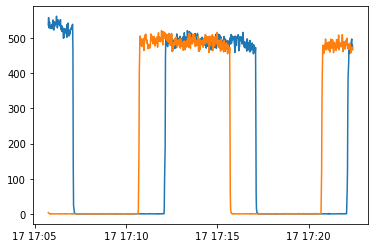

In [163]:
width = 1000 # Number of seconds to look at.
start = 6000 # Starting data point on raspi.
raspi_start_dt = raspi.index[start]
cpc_start_dt = cpc.index.get_loc(raspi_start_dt)
raspi_concs = raspi.concent[raspi_start_dt:raspi_start_dt + dt.timedelta(seconds=width)]
cpc_concs = cpc.concent[cpc_start_dt: cpc_start_dt + width] # Assume 1Hz cadence, be careful using this around datapoint 50000

plt.plot(raspi_concs)
plt.plot(cpc_concs)
plt.show()

While the values generally match, there's a clear delay associated with the communication over serial. We can characterize this drift for sure, but I would argue that it would be better to get the CPC timestamps in the raspberry pi log, as detailed in [Issue 44](https://github.com/airpartners/logger/issues/44). THat being said, because the values match so exactly (which would be alarming if it was not the case), characterizing the drift is straightforward by using either correlation/peak finding techniques or manually finding the offset for which the difference is least.

# Switching Cadence Validation
I can then analyze whether the valve switches between state `a` and `b` - I should expect switching every 300 secodns with very concentrations when in state `b` (as this is when its connected to the HEPA filter cartridge) and higher concentrations when in state `a` (as it samples air from the Olin academic center).
### Consistency in Timing
The first thing I want to check is the consistency of the timing of the switching, from the perspective of the raspberry pi logs. I can do this by pulling the `valve_state` variable. I can first make sure that the variable has similar numbers for states `a` and `b`, and then I can take a look at the consistency of each switch.

In [121]:
raspi.valve_state.value_counts()

a    27161
b    27111
Name: valve_state, dtype: int64

They're fairly balanced, which is sufficient for me for now. I can then validate the average number of measurements for each state. Because of frequency inconsistencies above, I don't expect this to be exact, but I expect it to only be a difference of a couple of measurements.

In [122]:
switch_period_in_logs = []
current_element = 'a'
current_count = 0
for element in raspi.valve_state:
    if element == current_element:
        current_count += 1
    else:
        switch_period_in_logs.append(current_count)
        current_element = element
        current_count = 0
Counter(switch_period_in_logs)

Counter({0: 1, 13: 1, 241: 206, 240: 18})

Given that the 0 and 13 are at the very beginning of data collection (potentially following a reset or something, this ought to be explored in the context of the 8 hours of missing data), this is acceptable performance for this application. 240-241 samples per state corresponds to 300 seconds of data with the 20 percent drop off visible in the frequency analysis section.
### Consistency in Values
I also should expect that a stated valve switch should also correspond to a dramatic difference in concentration
#### Aggregate Concentration 
I can start by just looking at the average concentration for each valve state. I should expect `a` to be dramatically higher than `b`. 

In [129]:
a_state_df = raspi[raspi['valve_state'] == 'a']
sum(a_state_df.concent)/len(a_state_df.concent) # get mean concentration

1638.3799642870263

In [130]:
b_state_df = raspi[raspi['valve_state'] == 'b']
sum(b_state_df.concent)/len(b_state_df.concent) # get mean concentration

24.398830732913567

This tracks with my expectations, which is good. While it's not a priority right now, a more granular analysis could look at how long the switching takes and how that affects the results, but for the time being it's more important to focus on switching consistently than to worry about characterizing the nature of the switch. 

## Conclusion
While this experiment shows some early markers of success (there's consistent valve switching happening and some data logging, even though it's inconsistent and not robust), there are a variety of issues we need to tackle to upgrade v1.0.0. to something we can reliably use in the field without having to do extensive timestep synchronization and cleaning following a deployment. Hopefully this notebook and associated GH issues provide some good insight into how the data look and how to move forward with improving this system, but feel free to file additional issues and modify things as needed.